# 🎮 Importation et découpage d'images SF6

Ce notebook permet d'importer des screenshots de SF6 depuis `input/screenshots/` et de découper la zone du timer pour créer un dataset d'entraînement.

## Étapes :
1. **Import des images** - Chargement des screenshots SF6
2. **Calibrage ROI** - Sélection interactive de la zone timer 
3. **Découpage automatique** - Application de la ROI sur toutes les images
4. **Sauvegarde dataset** - Export des découpes en PNG dans `notebooks/dataset/train/`

In [1]:
#import subprocess
#import sys

#subprocess.run([
#    sys.executable, '-m', 'pip', 'install', 'PyQt5'
#], capture_output=True, text=True, check=True)
#print("✅ PyQt5 installé via pip!")

#subprocess.run([
#    sys.executable, '-m', 'pip', 'install', 'ipympl'
#], capture_output=True, text=True, check=True)
#print("✅ ipympl installé via pip!")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# Utiliser GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Training sur : {device}")


✅ PyQt5 installé via pip!
✅ ipympl installé via pip!


## 1. 📂 Import des images SF6

📁 Répertoire: ../input/screenshots
🖼️  Images trouvées: 16
  ✅ 35.png - 1920x1080
  ✅ 36.png - 1920x1080
  ✅ 51.png - 1920x1080
  ✅ 64.png - 1920x1080
  ✅ 67.png - 1920x1080
  ✅ 71.png - 1920x1080
  ✅ 84.png - 1920x1080
  ✅ 89.png - 1920x1080
  ✅ 93.png - 1920x1080
  ✅ KO.png - 1920x1080
  ✅ Round1.png - 1920x1080
  ✅ Round2.png - 1920x1080
  ✅ SF6-01.jpg - 1920x1080
  ✅ SF6-03.png - 1280x720
  ✅ SF6-04.jpg - 1920x1080
  ✅ calibration.png - 1920x1080
  🎯 Image de référence détectée: calibration.png

✨ 16 images chargées avec succès!

🎯 Image de calibrage: calibration.png


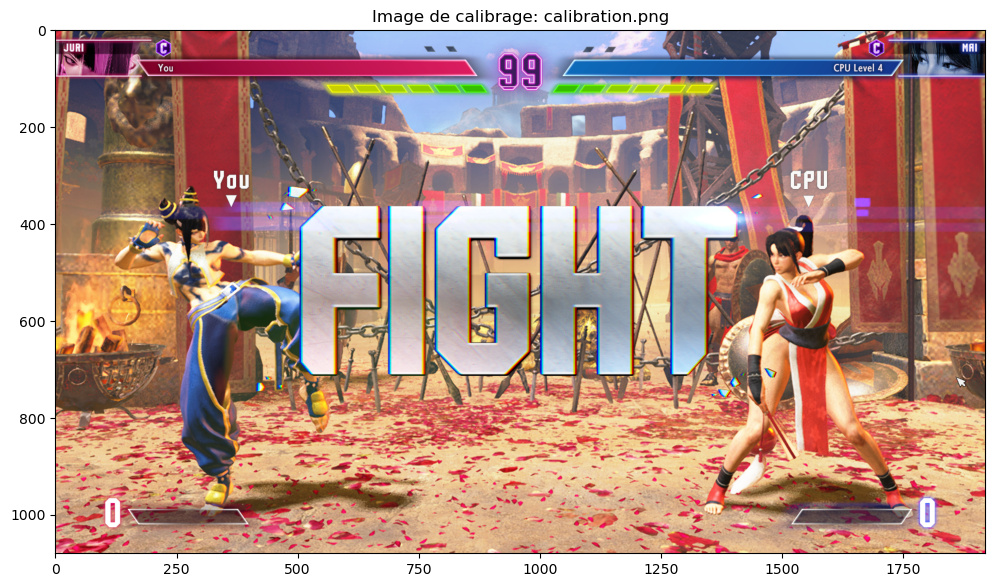

In [2]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Configuration des répertoires
INPUT_DIR = Path('../input/screenshots')
OUTPUT_DIR = Path('dataset/train')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Image de référence pour le calibrage
REFERENCE_IMAGE_NAME = "calibration.png"

# Chargement des images SF6
def load_sf6_images(input_dir):
    """Charge toutes les images depuis le répertoire input/screenshots/"""
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_paths = []
    
    for ext in image_extensions:
        image_paths.extend(glob.glob(str(input_dir / ext)))
        image_paths.extend(glob.glob(str(input_dir / ext.upper())))
    
    print(f"📁 Répertoire: {input_dir}")
    print(f"🖼️  Images trouvées: {len(image_paths)}")
    
    images = []
    reference_image = None
    
    for path in sorted(image_paths):
        img = cv.imread(path)
        if img is not None:
            images.append((path, img))
            print(f"  ✅ {os.path.basename(path)} - {img.shape[1]}x{img.shape[0]}")
            
            # Vérifier si c'est l'image de référence
            if os.path.basename(path) == REFERENCE_IMAGE_NAME:
                reference_image = (path, img)
                print(f"  🎯 Image de référence détectée: {REFERENCE_IMAGE_NAME}")
        else:
            print(f"  ❌ Impossible de charger: {os.path.basename(path)}")
    
    return images, reference_image

# Chargement des images
sf6_images, reference_img = load_sf6_images(INPUT_DIR)

if len(sf6_images) == 0:
    print("⚠️  Aucune image trouvée!")
    print(f"Vérifiez que le répertoire {INPUT_DIR} contient des images.")
else:
    print(f"\n✨ {len(sf6_images)} images chargées avec succès!")
    
    # Choix de l'image pour calibrage
    if reference_img:
        calibration_path, calibration_img = reference_img
        print(f"\n🎯 Image de calibrage: {REFERENCE_IMAGE_NAME}")
    else:
        # Fallback sur la première image
        calibration_path, calibration_img = sf6_images[0]
        print(f"\n⚠️  {REFERENCE_IMAGE_NAME} non trouvée, utilisation de: {os.path.basename(calibration_path)}")
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv.cvtColor(calibration_img, cv.COLOR_BGR2RGB))
    plt.title(f"Image de calibrage: {os.path.basename(calibration_path)}")
    plt.axis('on')
    plt.show()

## 2. 🎯 Calibrage ROI - Sélection de la zone timer

In [3]:
import os
os.environ['OPENCV_VIDEOIO_PRIORITY_MSMF'] = '0'
os.environ['OPENCV_UI_BACKEND'] = 'GTK'

import cv2 as cv
import numpy as np
import json
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

class TimerROISelector:
    """Version identique à color_picker.py pour sélection ROI"""
    
    def __init__(self, image_path):
        self.image = cv.imread(image_path)
        if self.image is None:
            raise FileNotFoundError(f"❌ Cannot load image: {image_path}")
        
        self.image_copy = self.image.copy()
        self.drawing = False
        self.start_point = None
        self.end_point = None
        self.rect_selected = False
        self.rectangle_mode = False
        self.roi_coords = None
        
    def mouse_callback(self, event, x, y, flags, param):        
        # Left click for rectangle drawing when in rectangle mode
        if event == cv.EVENT_LBUTTONDOWN and self.rectangle_mode:
            if not self.drawing:
                self.drawing = True
                self.start_point = (x, y)
                self.rect_selected = False
                print("🖱️  Drawing rectangle... Press R again to validate")
            
        elif event == cv.EVENT_MOUSEMOVE and self.drawing and self.rectangle_mode:
            self.image_copy = self.image.copy()
            cv.rectangle(self.image_copy, self.start_point, (x, y), (0, 255, 0), 1)
            self.update_window_title(self.start_point, (x, y))
            
        elif event == cv.EVENT_LBUTTONUP and self.drawing and self.rectangle_mode:
            self.end_point = (x, y)
            
    def update_window_title(self, start_point, end_point):
        """Met à jour le titre de la fenêtre avec les dimensions en temps réel"""
        x1, y1 = start_point
        x2, y2 = end_point
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)
        
        width = x_max - x_min
        height = y_max - y_min
        
        # Mise à jour du titre avec les dimensions
        title = f"Timer ROI Selection - {width}x{height}px - ({x_min},{y_min}) -> ({x_max},{y_max})"
        cv.setWindowTitle('Timer ROI Selection', title)

    def run(self):
        cv.namedWindow('Timer ROI Selection', cv.WINDOW_NORMAL)
        # Set window size to 70% of image for better visibility
        height, width = self.image.shape[:2]
        window_width = int(width * 0.7)
        window_height = int(height * 0.7)
        cv.resizeWindow('Timer ROI Selection', window_width, window_height)
        cv.setMouseCallback('Timer ROI Selection', self.mouse_callback)
        
        print("🔘 Press R to start rectangle mode")
        print("🖱️  Then LEFT CLICK + drag to draw rectangle")
        print("🔘 Press R again to validate rectangle")
        print("📋 Press ENTER or SPACE to save selected area")
        print("🔍 LEFT CLICK + drag to pan (auto-enabled when zoomed)")
        print("🔍 Zoom with mouse wheel")
        print("❌ Press ESC to exit")
        
        while True:
            cv.imshow('Timer ROI Selection', self.image_copy)
            key = cv.waitKey(1) & 0xFF
            
            if key == 27:  # ESC
                print("❌ Selection cancelled")
                break
            elif key == 13 and self.rect_selected:  # ENTER
                print("ENTER detected, saving selection...")
                self.save_selection()
                break
            elif key == 10 and self.rect_selected:  # Alternative ENTER code
                print("ENTER (alternative) detected, saving selection...")
                self.save_selection()
                break
            elif key == ord('r'):  # R
                self.handle_r_key()
            elif key == ord(' ') and self.rect_selected:  # SPACE as alternative
                print("SPACE detected, saving selection...")
                self.save_selection()
                break
                
        cv.destroyAllWindows()
        return self.roi_coords
        
    def handle_r_key(self):
        if not self.rectangle_mode:
            # Start rectangle mode
            self.rectangle_mode = True
            self.rect_selected = False
            cv.setWindowTitle('Timer ROI Selection', 'Timer ROI Selection - Rectangle mode ON')
            print("🔘 Rectangle mode ON - Click and drag to draw rectangle")
        elif self.drawing:
            # Validate current rectangle
            self.drawing = False
            self.rect_selected = True
            self.image_copy = self.image.copy()
            cv.rectangle(self.image_copy, self.start_point, self.end_point, (0, 255, 0), 1)
            
            # Calculer les dimensions finales pour le titre
            x1, y1 = self.start_point
            x2, y2 = self.end_point
            x_min, x_max = min(x1, x2), max(x1, x2)
            y_min, y_max = min(y1, y2), max(y1, y2)
            width = x_max - x_min
            height = y_max - y_min
            
            title = f"Timer ROI Selection - ✅ {width}x{height}px SELECTED - Press ENTER to save"
            cv.setWindowTitle('Timer ROI Selection', title)
            print("✅ Rectangle validated - Press ENTER to save")
        else:
            # Reset and exit rectangle mode
            self.rectangle_mode = False
            self.rect_selected = False
            self.drawing = False
            self.start_point = None
            self.end_point = None
            self.image_copy = self.image.copy()
            cv.setWindowTitle('Timer ROI Selection', 'Timer ROI Selection - Rectangle mode OFF')
            print("🔘 Rectangle mode OFF")

    def save_selection(self):
        if not self.rect_selected or not self.start_point or not self.end_point:
            print("⚠️  No valid selection")
            return
            
        # Ensure correct rectangle coordinates
        x1, y1 = self.start_point
        x2, y2 = self.end_point
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)
        
        self.roi_coords = {
            "x": x_min,
            "y": y_min, 
            "w": x_max - x_min,
            "h": y_max - y_min
        }
        
        print(f"\n🔍 ROI selected: ({x_min},{y_min}) to ({x_max},{y_max})")
        print(f"📐 Size: {self.roi_coords['w']}x{self.roi_coords['h']} pixels")

# --- Configuration ---
image_path = "../input/screenshots/calibration.png"
selector = None
result_roi = None

# Vérification de l'image
try:
    test_image = cv.imread(image_path)
    if test_image is None:
        print(f"❌ Image introuvable: {image_path}")
    else:
        print(f"✅ Image chargée: {image_path} - {test_image.shape[1]}x{test_image.shape[0]}px")
        selector = TimerROISelector(image_path)
except Exception as e:
    print(f"❌ Erreur lors du chargement: {e}")

# --- Interface avec bouton ---
def on_button_click(b):
    global result_roi
    with output:
        clear_output()
        print("🚀 Lancement de la sélection ROI...")
        
        if selector is None:
            print("❌ Pas de sélecteur disponible")
            return
            
        try:
            result_roi = selector.run()
            
            if result_roi:
                # Sauvegarde
                with open("roi_config.json", "w") as f:
                    json.dump(result_roi, f, indent=2)
                print(f"✅ ROI saved to roi_config.json: {result_roi}")
                
                # Affichage de la zone dans le notebook
                image = cv.imread(image_path)
                image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                
                x, y, w, h = result_roi["x"], result_roi["y"], result_roi["w"], result_roi["h"]
                roi_preview = image_rgb[y:y+h, x:x+w]
                
                if roi_preview.size > 0:
                    plt.figure(figsize=(10, 6))
                    plt.imshow(roi_preview)
                    plt.title(f"Zone sélectionnée - {w}x{h}px")
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
            else:
                print("❌ No ROI selected")
                
        except Exception as e:
            print(f"❌ Error: {e}")

# Création du bouton et de la zone de sortie
button = widgets.Button(
    description='🎯 Ouvrir sélection ROI',
    button_style='info',
    layout=widgets.Layout(width='200px', height='40px')
)
button.on_click(on_button_click)

output = widgets.Output()

# Affichage de l'interface
print("📋 Interface de sélection ROI prête.")
print(f"🖥️  OpenCV backend: {os.environ.get('OPENCV_UI_BACKEND', 'GTK')}")
display(button, output)

✅ Image chargée: ../input/screenshots/calibration.png - 1920x1080px
📋 Interface de sélection ROI prête.
🖥️  OpenCV backend: GTK


Button(button_style='info', description='🎯 Ouvrir sélection ROI', layout=Layout(height='40px', width='200px'),…

Output()

## 3. ✂️ Découpage automatique - Application de la ROI sur toutes les images

In [4]:
def crop_timer_from_images(images, roi_coords, output_dir):\n    \"\"\"Découpe la zone timer de toutes les images et les sauvegarde\"\"\"\n    if not roi_coords:\n        print(\"❌ Aucune ROI définie! Veuillez d'abord calibrer la zone.\")\n        return []\n    \n    x_min, y_min, x_max, y_max = roi_coords\n    processed_images = []\n    failed_images = []\n    \n    print(f\"✂️  Découpage de {len(images)} images...\")\n    print(f\"📐 ROI: ({x_min},{y_min}) -> ({x_max},{y_max}) - {x_max-x_min}x{y_max-y_min}px\")\n    print(f\"💾 Sortie: {output_dir}\")\n    \n    for i, (img_path, img) in enumerate(images):\n        try:\n            # Vérification des dimensions\n            img_height, img_width = img.shape[:2]\n            if x_max > img_width or y_max > img_height:\n                print(f\"  ⚠️  {os.path.basename(img_path)}: ROI dépasse les dimensions ({img_width}x{img_height})\")\n                failed_images.append(img_path)\n                continue\n            \n            # Découpage de la ROI\n            timer_crop = img[y_min:y_max, x_min:x_max]\n            \n            if timer_crop.size == 0:\n                print(f\"  ❌ {os.path.basename(img_path)}: Découpe vide\")\n                failed_images.append(img_path)\n                continue\n            \n            # Génération du nom de fichier de sortie\n            base_name = os.path.splitext(os.path.basename(img_path))[0]\n            output_filename = f\"timer_{i:04d}_{base_name}.png\"\n            output_path = output_dir / output_filename\n            \n            # Sauvegarde\n            success = cv.imwrite(str(output_path), timer_crop)\n            \n            if success:\n                processed_images.append((output_path, timer_crop))\n                print(f\"  ✅ {i+1:3d}/{len(images)} - {output_filename}\")\n            else:\n                print(f\"  ❌ {os.path.basename(img_path)}: Échec sauvegarde\")\n                failed_images.append(img_path)\n                \n        except Exception as e:\n            print(f\"  ❌ {os.path.basename(img_path)}: Erreur - {str(e)}\")\n            failed_images.append(img_path)\n    \n    print(f\"\\n✨ Découpage terminé:\")\n    print(f\"   ✅ Réussies: {len(processed_images)}\")\n    print(f\"   ❌ Échouées: {len(failed_images)}\")\n    \n    if failed_images:\n        print(f\"\\n⚠️  Images échouées:\")\n        for failed in failed_images:\n            print(f\"   - {os.path.basename(failed)}\")\n    \n    return processed_images\n\n# Lancement du découpage si la ROI est définie\nif 'timer_roi' in locals() and timer_roi is not None:\n    print(\"🚀 Lancement du découpage automatique...\")\n    cropped_timers = crop_timer_from_images(sf6_images, timer_roi, OUTPUT_DIR)\n    \n    if cropped_timers:\n        print(f\"\\n🎯 Aperçu des premières découpes:\")\n        \n        # Affichage des 6 premières découpes\n        preview_count = min(6, len(cropped_timers))\n        \n        fig, axes = plt.subplots(2, 3, figsize=(15, 8))\n        axes = axes.flatten()\n        \n        for i in range(preview_count):\n            output_path, timer_crop = cropped_timers[i]\n            \n            axes[i].imshow(cv.cvtColor(timer_crop, cv.COLOR_BGR2RGB))\n            axes[i].set_title(f\"{os.path.basename(output_path)}\\n{timer_crop.shape[1]}x{timer_crop.shape[0]}px\")\n            axes[i].axis('off')\n        \n        # Masquer les axes non utilisés\n        for i in range(preview_count, 6):\n            axes[i].axis('off')\n        \n        plt.tight_layout()\n        plt.suptitle(f\"Aperçu des découpes timer ({len(cropped_timers)} au total)\", y=1.02)\n        plt.show()\n        \nelse:\n    print(\"❌ Aucune ROI calibrée. Veuillez d'abord exécuter la cellule de calibrage.\")"

SyntaxError: unexpected character after line continuation character (317560454.py, line 1)

## 4. 📊 Chargement du dataset

In [ ]:
class TimerDigitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label_str in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_str)
            if os.path.isdir(label_path):
                label = int(label_str)
                for img_name in os.listdir(label_path):
                    if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.samples.append((os.path.join(label_path, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## 3 – Transformations et DataLoaders

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation simple
])

train_dataset = TimerDigitsDataset("dataset/train", transform=transform)
test_dataset  = TimerDigitsDataset("dataset/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"📂 {len(train_dataset)} images pour l'entraînement")
print(f"📂 {len(test_dataset)} images pour le test")

## 4 – Modèle CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

# --- Dataset personnalisé ---
class ChiffresDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        # On suppose une structure :
        # root_dir/
        #    0/
        #      img1.png
        #      img2.png
        #    1/
        #      ...
        for label_str in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label_str)
            if not os.path.isdir(label_path):
                continue
            label = int(label_str)
            for fname in os.listdir(label_path):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((os.path.join(label_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGBA")  # RGBA pour garder transparence

        # Centrage dans 76x76 sans déformer
        base_img = Image.new("RGBA", (76, 76), (0, 0, 0, 0))  # fond transparent
        offset_x = (76 - img.width) // 2
        offset_y = (76 - img.height) // 2
        base_img.paste(img, (offset_x, offset_y), img)

        if self.transform:
            base_img = self.transform(base_img)

        return base_img, label


# --- Transforms ---
train_transforms = transforms.Compose([
    transforms.RandomRotation(2),  # petite rotation réaliste
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(0, translate=(0.02, 0.02)),  # petit décalage
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

# --- Dataset ---
train_dataset = ChiffresDataset("data/chiffres/train", transform=train_transforms)
test_dataset = ChiffresDataset("data/chiffres/test", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# --- Modèle simple pour 76x76 ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),  # 4 canaux (RGBA)
            nn.ReLU(),
            nn.MaxPool2d(2),  # 76 -> 38
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 38 -> 19
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 19 * 19, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 chiffres
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 5 – Entraînement

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"📅 Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f} - Acc: {100*correct/total:.2f}%")

## 6 – Évaluation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Accuracy sur le test: {100*correct/total:.2f}%")

## 7 – Sauvegarde du modèle

In [ ]:
torch.save(model.state_dict(), "timer_cnn_sf6.pth")
print("💾 Modèle sauvegardé sous timer_cnn_sf6.pth")